parameter setting: p=240, q=80, res=80, following optimal sampling
Time of creation of phantom: 0.00 seconds
Time of generation of measured data: 0.21 seconds
Start back projection
Time of back projection: 16.97 seconds


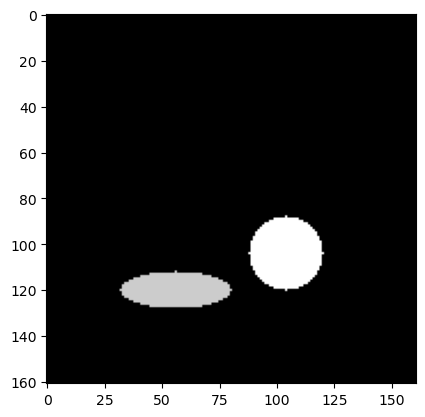

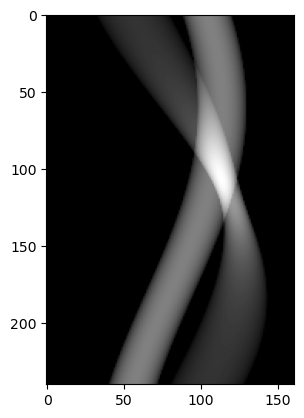

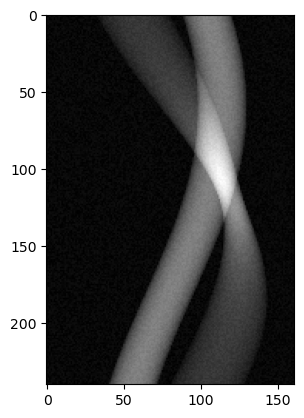

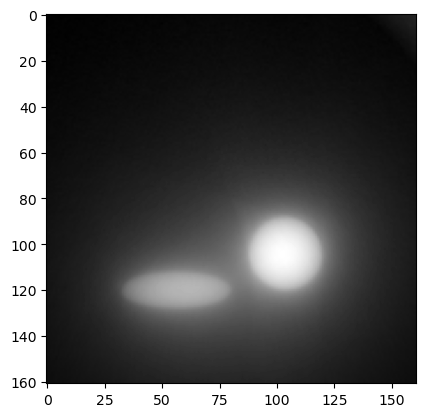

In [33]:
import numpy as np
from scipy.fftpack import fft, ifft, fftshift
import matplotlib.pyplot as plt
import time 

RAMLAK = 0
SHEPPLOGAN = 1
COSINE = 2

def init_objects():
    # Initialize circle parameters
    # Each row: [radius, center_x, center_y, gray_value]
    circle_objects = np.array([
        [0.2, 0.3, 0.3, 1.0]
    ])
    
    # Initialize ellipse parameters (optional)
    # Each row: [semi-major, semi-minor, center_x, center_y, angle, gray_value]
    ellipse_objects = np.array([
        [0.3, 0.1, -0.3, 0.5, 0, 0.8]
    ])
    
    return circle_objects, ellipse_objects

def create_phantom(circle_objects=None, ellipse_objects = None, res = 5):
    time_start = time.time()
    # Create a phantom image based on given objects
    phantom = np.zeros((2*res+1, 2*res+1))

    if circle_objects is not None:
        for params in circle_objects:
            phantom += phantom_circle(params, res)
    if ellipse_objects is not None:
        for params in ellipse_objects:
            phantom += phantom_ellipse(params, res)

    if np.sum(phantom)<1:
        print('Warning: object lists are empty.')
    print(f"Time of creation of phantom: {time.time()-time_start:.2f} seconds")
    return phantom

def phantom_circle(parameters, res):
    radius, center_x, center_y, gray_value = parameters
    x = np.linspace(-1, 1, 2*res+1)
    y = np.linspace(-1, 1, 2*res+1)
    xv, yv = np.meshgrid(x, y)
    mask = (xv - center_x)**2 + (yv - center_y)**2 <= radius**2
    return gray_value * mask

def phantom_ellipse(parameters, res):
    semi_major, semi_minor, center_x, center_y, angle, gray_value = parameters
    x = np.linspace(-1, 1, 2*res+1)
    y = np.linspace(-1, 1, 2*res+1)
    xv, yv = np.meshgrid(x, y)
    mask = ((xv - center_x) * np.cos((angle)) + (yv - center_y) * np.sin(angle))**2 / semi_major**2 + ((xv - center_x) * np.sin(angle) - (yv - center_y) * np.cos(angle))**2 / semi_minor**2 <= 1
    return gray_value * mask

def generate_measured_data(p, q, circle_objects=None, ellipse_objects=None):
    start_time = time.time()
    if circle_objects is not None and ellipse_objects is not None:
        delta_phi = np.pi / p
        phi = np.arange(p) * delta_phi
        s = np.linspace(-1, 1, 2*q+1)
        
        sinogram = np.zeros((p, 2*q+1))

        for i in range(p):
            omega = np.array([np.cos(phi[i]), np.sin(phi[i])]) #create omega vector
            for j in range(-q, q+1):
                sinogram[i, j+q] += calculate_radon_transform_circle(circle_objects, s[j+q], omega)
                sinogram[i, j+q] += calculate_radon_transform_ellipse(ellipse_objects, s[j+q], phi[i])
    else:
        print('Warning: object lists are empty.')
        sinogram = None
        phi = None
        s = None
    print(f"Time of generation of measured data: {time.time()-start_time:.2f} seconds")
    return sinogram, phi, s

def generate_measured_data_integration(p, q, phantom, res):
    """
    Generate measured data (sinogram) for given phantom using trapezoidal rule.

    Parameters:
    p (int): Number of projection angles.
    q (int): Number of detectors per projection.
    phantom (np.array): Phantom image.
    res (int): Resolution of the phantom.

    Returns:
    np.array: Generated sinogram.
    np.array: Projection angles (phi).
    np.array: Detector positions (s).
    """
    time_start = time.time()
    delta_phi = np.pi / p
    phi = np.arange(p) * delta_phi
    # delta_s = 2 / (2*q)
    s = np.linspace(-1, 1, 2*q+1)
    
    sinogram = np.zeros((p, 2*q+1))
    for i in range(p):
        omega = np.array([np.cos(phi[i]), np.sin(phi[i])])
        for j in range(-q, q+1):
            sinogram[i, j+q] = trapezoidal_integration(phantom, s[j+q], omega, res)
    print(f"Time of generation of measured data: {time.time()-time_start:.2f} seconds")
    return sinogram, phi, s

def generate_measured_data_integration_v2(p, q, phantom, res):
    delta_phi = np.pi / p
    phi = np.arange(p) * delta_phi

    image = phantom
    diagonal = np.sqrt(2) * max(image.shape) # diagonal of the rectangular image
    pad = [int(np.ceil(diagonal - s)) for s in image.shape]
    new_center = [(s + p) // 2 for s, p in zip(image.shape, pad)]
    old_center = [s // 2 for s in image.shape]
    pad_before = [nc - oc for oc, nc in zip(old_center, new_center)]
    pad_width = [(pb, p - pb) for pb, p in zip(pad_before, pad)]
    padded_image = np.pad(image, pad_width, mode='constant', constant_values=0)

    # padded_image is always square
    if padded_image.shape[0] != padded_image.shape[1]:
        raise ValueError('padded_image must be a square')
    center = padded_image.shape[0] // 2
    radon_image = np.zeros((padded_image.shape[0], len(phi)), dtype=image.dtype)
    for i, angle in enumerate(phi):
        cos_a, sin_a = np.cos(angle), np.sin(angle)
        R = np.array(
            [
                [cos_a, sin_a, -center * (cos_a + sin_a - 1)],
                [-sin_a, cos_a, -center * (cos_a - sin_a - 1)],
                [0, 0, 1],
            ]
        )

        #rotate the image 
        rotated = np.zeros_like(padded_image)
        for x in range(padded_image.shape[0]):
            for y in range(padded_image.shape[1]):
                new_x = int(np.round(R[0,0]*x + R[0,1]*y + R[0,2]))
                new_y = int(np.round(R[1,0]*x + R[1,1]*y + R[1,2]))
                if 0 <= new_x < padded_image.shape[0] and 0 <= new_y < padded_image.shape[1]:
                    rotated[new_x, new_y] = padded_image[x, y]
        radon_image[:,i] = np.sum(rotated, axis=0)
    return radon_image

def trapezoidal_integration(phantom, s, omega, res:int):
    """
    Perform trapezoidal integration to compute the Radon transform.

    Parameters:
    phantom (np.array): Phantom image.
    s (float): Detector position.
    omega (np.array): Projection direction.
    res (int): Resolution of the phantom.

    Returns:
    float: Integrated value.
    """
    step_size = 1 / ( res)
    integral_sum = 0.0
    for k in range(2 * res + 1):
        point = (s * omega[0] - (res - k) * step_size * omega[1],
                 s * omega[1] + (res - k) * step_size * omega[0])
        row, col = EvaluateMatrix(point, res)

        if 0 <= row < phantom.shape[0] and 0 <= col < phantom.shape[1]:
            integral_sum += phantom[row, col]
    
    # integral_value = step_size * (integral_sum - 0.5 * (phantom[row_min, col_min] + phantom[row_max, col_max]))
    integral_value = step_size * (integral_sum - 0.5 * (phantom[0, 0] + phantom[-1, -1]))
    return integral_value

def EvaluateMatrix(point, res):
    """
    Evaluate the phantom at a given point (x, y).

    Parameters:
    point (tuple): Coordinates (x, y) of the point to evaluate.
    res (int): Resolution of the phantom.
    phantom (np.array): Phantom image.

    Returns:
    int: Matrix row index corresponding to the point.
    int: Matrix column index corresponding to the point.
    """
    x, y = point
    row = int((y + 1) * res)
    col = int((x + 1) * res)
    return row, col

def calculate_radon_transform_circle(circle_data, s, omega):
    radon_value = 0
    for circle in circle_data:
        radius, center_x, center_y, gray_value = circle
        term = radius**2 - (s - center_x * omega[0] - center_y * omega[1])**2
        if term > 0:
            projection = gray_value * np.sqrt(term) * 2 
            radon_value += projection
    return radon_value

def calculate_radon_transform_ellipse(ellipse_data, s, phi):
    radon_value = 0
    for ellipse in ellipse_data:
        semi_major, semi_minor, center_x, center_y, angle, gray_value = ellipse
        omega = np.array([np.cos(phi- angle), np.sin(phi- angle)])
        denom_square = (semi_major * omega[0]) **2 + (semi_minor * omega[1]) **2
        term = denom_square - (s - center_x * omega[0] - center_y * omega[1])**2
        if term > 0:
            projection = 2* gray_value  * semi_major * semi_minor * np.sqrt(term) / (denom_square)
            radon_value += projection

    return radon_value

def add_noise(sinogram, noise_level):
    noise = np.random.rand(*sinogram.shape) * noise_level
    sinogram_noisy = sinogram + noise
    return sinogram_noisy

def filtered_back_projection(sinogram, p, q, filter_choice, res):

    delta_phi = np.pi / p
    phi = np.arange(p) * delta_phi
    s = np.linspace(-1, 1, 2*q+1)

    # Calculate the filte4r
    # b = 0.96
    filter = calculate_filter(s, q*np.pi, filter_choice)

    start_time = time.time()
    if filter_choice is not None:
        print("start filtering")
        filtered_sinogram = calculate_convolution(sinogram, p, q, filter)
        plot(filtered_sinogram)
    else:
        filtered_sinogram = sinogram
    # Back projection
    print("Start back projection")
    start_time = time.time()
    fFBI = np.zeros((2*res+1, 2*res+1))
    for x in range(-res, res+1):
        for y in range(-res, res+1):
            for i in range(p):
                # omega = np.array([np.cos(phi[i]), np.sin(phi[i])])
                omega = np.array([np.sin(phi[i]), np.cos(phi[i])])
                s_xy = x * omega[0] + y * omega[1]
                if s_xy > res-1:
                    fFBI[x+res, y+res] += filtered_sinogram[i, 2*q]
                elif s_xy >=q-1:
                    continue
                else:
                    u = s_xy - int(s_xy)
                    assert int(s_xy) < q-1, f"s_xy:{s_xy:.2f}, q:{q}"
                    fFBI[x+res, y+res] += (1-u)*filtered_sinogram[i, int(s_xy+q)] + u*filtered_sinogram[i, int(s_xy+q)+1]

    print(f"Time of back projection: {time.time()-start_time:.2f} seconds")
    return fFBI*np.pi/p


def calculate_filter(s,b = 0.5, filterchoice = RAMLAK):
    """
    s: vector
    b: cut-off frequency
    This part is based on the lecture notes which I believe is correct
    """

    filter = np.ones_like(s)
    
    q = len(s)//2
    if filterchoice == RAMLAK:
        # coef = np.sqr(b/2/np.pi)
        coef = 0.5*(b/np.pi)**2
        for i in range(-q, q+1):
            # r = (np.cos(s[i])**2 -1+s[i]*np.sin(s[i]) / np.sqr(s[i])) if s[i] != 0 else 0.5
            # filter[i] = coef * r
            if i == 0:
                r = 0.25
            elif i%2 == 0:
                r = 0
            else:
                r = -1/(i*np.pi)**2
            filter[i+q] = coef * r
    elif filterchoice == SHEPPLOGAN:
        for i in range(-q,q+1):
            filter[i+q] = (b/np.pi/np.pi)**2/(1-4*i*i)

    return filter

def calculate_convolution(sinogram, p,q, filter):
    filtered_sinogram = np.zeros_like(sinogram)
    assert len(filter)==sinogram.shape[1], f"filter:{len(filter)}, sinogram:{sinogram.shape[1]}"

    vector = np.append(filter[::-1],filter[::-1])
    for i in range(p):
        for j in range(2*q+1):
            # convolve the filter with the sinogram
            sino = sinogram[i,:]
            # assert sino.shape[0] == 2*q+1, f"sinogram:{sino.shape[0]}, q:{q}"
            filtered_sinogram[i,j] = np.sum(vector[2*q+1-j:2*(q+1)-j]*sino)
    return filtered_sinogram

def plot(sinogram):
    fig, ax = plt.subplots()
    ax.imshow(sinogram, cmap='gray')

p = 240
# q = int(p/np.pi)
q = 80
res = 80
print(f"parameter setting: p={p}, q={q}, res={res}, following optimal sampling")
noiselevel = 0.05
# Initialize objects
circle_objects, ellipse_objects = init_objects()

# Create phantom
phantom = create_phantom(circle_objects, ellipse_objects, res)  # Assuming resolution 128

fig, ax = plt.subplots()
ax.imshow(phantom, cmap='gray')

# Generate measured data
sinogram, phi, s = generate_measured_data(p, q, circle_objects, ellipse_objects)  # Example values for p and q

fig, ax = plt.subplots()
ax.imshow(sinogram, cmap='gray')

# sinogram,_,_ = generate_measured_data_integration(p, q, phantom, res)
sinogram_noisy = add_noise(sinogram, noiselevel)  # Example noise level
fig, ax = plt.subplots()
ax.imshow(sinogram_noisy, cmap='gray')

# Filtered back projection
filter_choice = None  # Example filter, replace with your filter choice
reconstructed_image = filtered_back_projection(sinogram_noisy, p, q, filter_choice, res)

fig, ax = plt.subplots()
ax.imshow(reconstructed_image, cmap='gray')

In [24]:
arr = np.array(([1,2,3,4,5]))
arr2 = np.array(([1,1,0,1,1]))
# print(np.fliplr(arr))   
# arr = 
print(arr[::-1])
vec = np.append(arr[::-1],arr[::-1])
print(vec)
for i in range(5):
    print(vec[5-i:10-i])
    print(np.dot(vec[5-i:10-i],arr2))
    print(np.sum(vec[5-i:10-i]*arr2))
# print(vec[])

[5 4 3 2 1]
[5 4 3 2 1 5 4 3 2 1]
[5 4 3 2 1]
12
12
[1 5 4 3 2]
11
11
[2 1 5 4 3]
10
10
[3 2 1 5 4]
14
14
[4 3 2 1 5]
13
13


Time of generation of measured data: 2.02 seconds
Start back projection
Time of back projection: 4.59 seconds


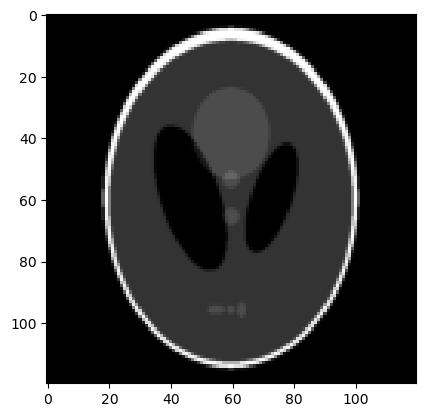

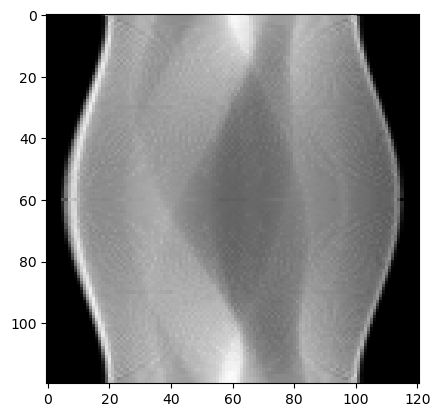

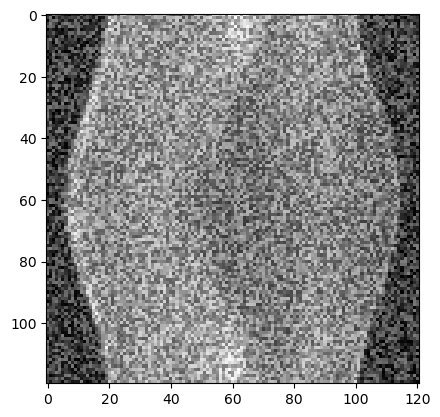

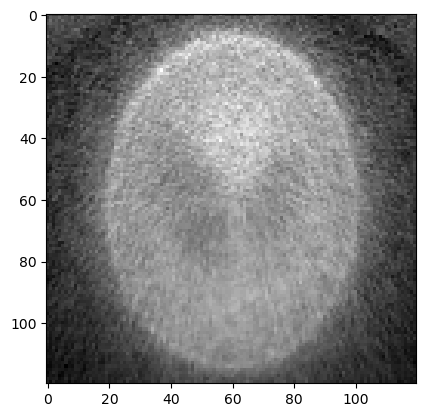

In [36]:
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, rescale
true_obj = shepp_logan_phantom()
true_obj = rescale(0.1*true_obj, scale = 0.3)
fig, ax = plt.subplots()
ax.imshow(true_obj, cmap='gray')

# print(true_obj.shape)
res = 60
p = 120
q = 60
signogram, phi, s = generate_measured_data_integration(p, q, true_obj, res)  # Example values for p and q
fig, ax = plt.subplots()
ax.imshow(signogram, cmap='gray')



signogram_noisy = add_noise(signogram, noiselevel)  # Example noise level
fig, ax = plt.subplots()
ax.imshow(signogram_noisy, cmap='gray')

filter_choice = None  # Example filter, replace with your filter choice
reconstructed_image = filtered_back_projection(signogram_noisy, p, q, filter_choice, res)

fig, ax = plt.subplots()
ax.imshow(reconstructed_image[:true_obj.shape[0],:true_obj.shape[1]], cmap='gray')

### Part 3 

In [10]:
import math
import numpy as np
def Kaczmarz(A, g, lamb=1, numberofiterations=50):
    """
    A: system matrix, shape: (p, 2q+1, M)
    g: sinogram, shape: (p, 2q+1)
    lamb: relaxation parameter
    numberofiterations: number of iterations
    """
    assert A.shape[0] == g.shape[0], f"{A.shape[0]}!={g.shape[0]}"
    assert A.shape[1] == g.shape[1]
    x = np.zeros(A.shape[2])
    img = np.zeros(A.shape[2])

    for _ in range(int(numberofiterations/10)):
        for i in range(A.shape[0]):
            for j in range(A.shape[1]):
                for _ in range(10):
                    x[:] = x[:] + lamb * (g[i,j] - np.dot(A[i,j,:], x)) * A[i,j, :] / np.dot(A[i,j, :], A[i,j,:])

    return x

def calculateA(p, q, res):
    """
    a_im = length of intersection, if detector j is in the i-th pixel, 0 otherwise
    """
    delta_phi = np.pi / p
    phi = np.arange(p) * delta_phi
    s = np.linspace(-res, res, 2*q+1)

    pre_A = np.zeros((p,2*q+1, (2*res+1)*( 2*res+1)),dtype=np.float16)

    for i in range(p):
        print(f"phi: {i}")
        for j in range(2*q+1):
            pre_A[i,j, :] = calculate_pixel_intersections(phi[i], s[j], res)
    return pre_A
 
def _round(x):
    #original grid
    if x > 0:
        return math.ceil(x) if x-int(x) >= 0.5 else math.floor(x)
    elif x < 0:
        return math.floor(x) if int(x)-x >= 0.5 else math.ceil(x)
    else:
        return 0
def _int(x):
    #new grid
    if x < 0:
        return int(x)-1.5 if int(x) -x>0.5 else int(x)-0.5
    elif x > 0:
        return int(x)+0.5 if x- int(x)>=0.5 else int(x)-0.5
    else:
        return 0
def calculate_pixel_intersections(phi,s,res):
    """
    return shape: (M,)
    """
    A = np.zeros((2*res+1, 2*res+1),dtype=np.float16)
    omega = np.array([np.cos(phi), np.sin(phi)])
    
    x_max = res+0.5
    y_max = res+0.5

    if omega[1]==0: #0 degree
        x = s
        A[_round(x)+res, :] = 1
    elif omega[0]==0: #90 degree
        y = s
        A[ :, _round(y)+res] = 1
    else:
        inv_grad = -omega[1]/omega[0]
        grad= -omega[0]/omega[1]
        l_y = -1/omega[0] #delta y =1, when cos>0, l_y<0
        l_x = 1/omega[1] #delta x =1 >0
        s_cos = s/omega[0]
        s_sin = s/omega[1] #s = xcos + ysin
        
        if omega[0] < 0: # -cot>0, grad>0, l_y>0, l_x>0
            y = -y_max
            x = s_cos + y*inv_grad
            if x < -x_max:
                x = -x_max
                y = grad * x + s_sin
                if y> y_max:
                    return A.flatten('F')
            elif x >x_max:  
                return A.flatten('F')    

            # print("here")       
            while x < x_max and y < y_max: 
                delta_x = _int(x)+1 - x
                delta_y = _int(y)+1 - y
                if delta_x * grad <= delta_y: #_int(x)+1
                    # assert _round(x+0.5*delta_x)+res < 2*res+1 and _round(y)+res<2*res +1, f"{x},{y},{delta_x}, {delta_y}"
                    A[_round(x+0.5*delta_x)+res, _round(y)+res] = l_x * delta_x
                    y += delta_x * grad
                    x = _int(x)+1
                    # print(f"1\n{x:.2f},{y:.2f}")
                else:
                    assert _round(x)+res < 2*res+1 and _round(y+0.5*delta_y)+res<2*res +1, f"{x},{y},{delta_x}, {delta_y}"
                    A[_round(x)+res, _round(y+0.5*delta_y)+res] = l_y * delta_y
                    x += delta_y * inv_grad
                    y = _int(y)+1

                    # print(f"2\n{x:.2f},{y:.2f}")

        elif omega[0]>0 :# -cot<0, grad<0, l_y<0, l_x>0
            #BUG
            y = y_max
            x = s_cos + y*inv_grad
            if x < -x_max:
                x = -x_max
                y = grad * x + s_sin
                if y< -y_max:
                    return A.flatten('F')
            elif x >x_max:
                return A.flatten('F')
            # print("k<0")
            while x < x_max and y > -y_max:
                delta_x = _int(x)+1 - x
                delta_y = _int(y) -y if y!=_int(y) else -1
                # print(f"update")
                if delta_x * grad >= delta_y:
                    y += delta_x * grad #grad<0
                    assert _round(x+0.5*delta_x)+res < 2*res+1 and _round(y)+res<2*res +1, f"{x:.2f},{y:.2f},{delta_x:.2f}, {delta_y:.2f}"
                    A[_round(x+0.5*delta_x)+res, _round(y)+res] = l_x * delta_x
                    
                    x = _int(x)+1
                    # print(f"3\n{x:.2f},{y:.2f}")
                else:
                    assert _round(x)+res < 2*res+1 and _round(y+0.5*delta_y)+res<2*res +1, f"{x:.2f},{y:.2f},{delta_x:.2f}, {delta_y:.2f}"
                    A[_round(x)+res, _round(y+0.5*delta_y)+res] = l_y * delta_y
                    x += delta_y * inv_grad #inv_grad<0, delta_y<0
                    y = _int(y)
                    # print(f"4\n{x:.2f},{y:.2f}")
    return A.flatten('F')

In [5]:
# once you've saved it, you can load it with np.load()
A = calculateA(p, q, res)
np.save("A_matrix.npy", A)
# better try with res = 100, p=180, q=100

NameError: name 'calculateA' is not defined

In [8]:
A = np.load("A_matrix.npy")

# based on previous sinogram
image_vec = Kaczmarz(A, sinogram_noisy, lamb=1, numberofiterations=70)
reconstructed_image = image_vec.reshape((2*res+1, 2*res+1))
fig, ax = plt.subplots()
ax.imshow(reconstructed_image, cmap='gray')

180
100
100


FileNotFoundError: [Errno 2] No such file or directory: 'A_matrix.npy'

res = 100, p=180, q=100

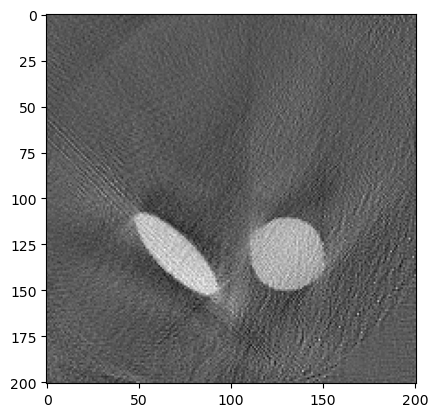

In [11]:
image_vec = Kaczmarz(A, sinogram_noisy, lamb=1, numberofiterations=70)
reconstructed_image = image_vec.reshape((2*res+1, 2*res+1))
fig, ax = plt.subplots()
ax.imshow(reconstructed_image, cmap='gray')

res = 100, p=180, q=100

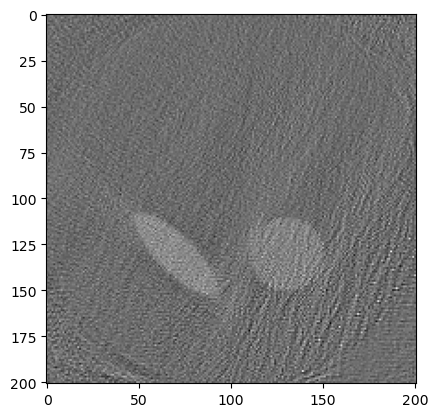

In [5]:
image_vec = Kaczmarz(A, sinogram_noisy, lamb=1, numberofiterations=70)
reconstructed_image = image_vec.reshape((2*res+1, 2*res+1))
fig, ax = plt.subplots()
ax.imshow(reconstructed_image, cmap='gray')

res = 100, p=180, q=100

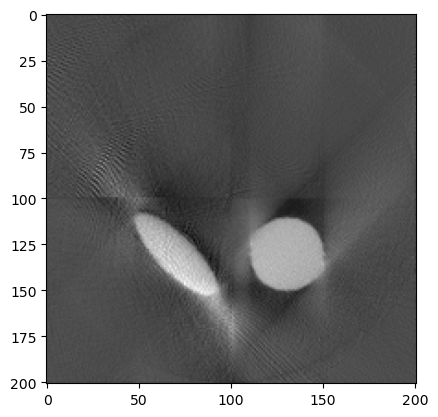

In [3]:
A = np.load("A_p180_q100_res100.npy")
assert A.shape == (p,2*q+1, (2*res+1)*(2*res+1)), f"{A.shape}"
assert A.min() >= 0, f"{A.min()}"

image_vec = Kaczmarz(A, sinogram_noisy, lampb=1, numberofiterations=160)
reconstructed_image = image_vec.reshape((2*res+1, 2*res+1))
fig, ax = plt.subplots()
ax.imshow(reconstructed_image, cmap='gray')

start filtering
Time of convolution: 0.02 seconds
start back projection
Time of back projection: 33.41 seconds


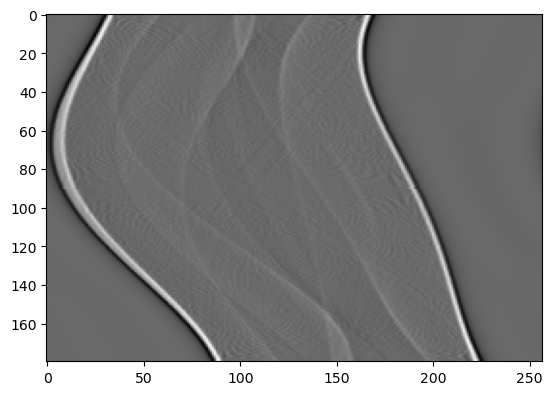

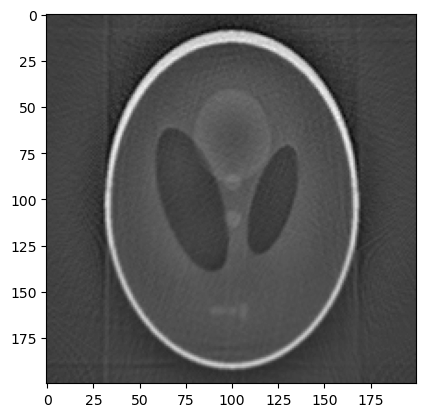

In [11]:
filter_choice = SHEPPLOGAN  # Example filter, replace with your filter choice
reconstructed_image = filtered_back_projection(signogram_noisy, p, q, filter_choice, res)

fig, ax = plt.subplots()
ax.imshow(reconstructed_image[:200,:200], cmap='gray')

start filtering
Time of convolution: 0.01 seconds
start back projection
Time of back projection: 31.28 seconds


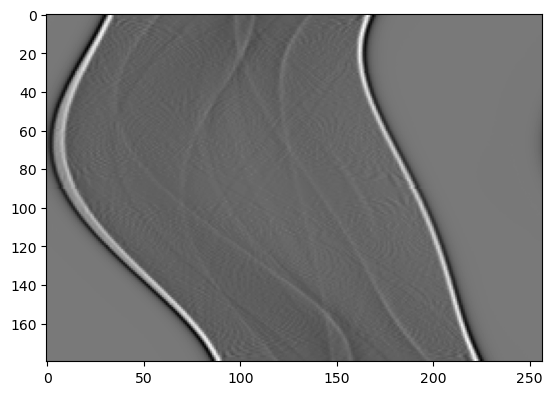

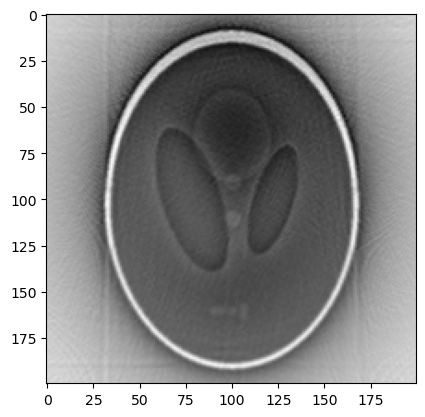

In [12]:
filter_choice = COSINE  # Example filter, replace with your filter choice
reconstructed_image = filtered_back_projection(signogram_noisy, p, q, filter_choice, res)

fig, ax = plt.subplots()
ax.imshow(reconstructed_image[:200,:200], cmap='gray')

start filtering
Time of convolution: 0.01 seconds
start back projection
Time of back projection: 32.49 seconds


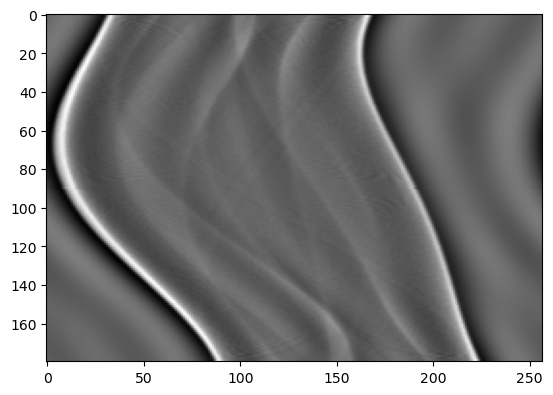

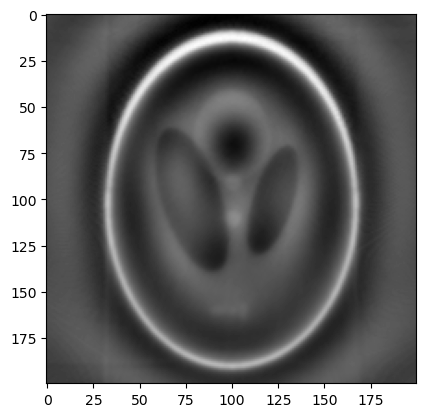

In [13]:
filter_choice = RAMLAK  # Example filter, replace with your filter choice
reconstructed_image = filtered_back_projection(signogram_noisy, p, q, filter_choice, res)

fig, ax = plt.subplots()
ax.imshow(reconstructed_image[:200,:200], cmap='gray')